In [1]:
Name= "Mahdi Mansouri"
Student_id = "402104499"

# Import necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

## Kernel kmeans implementation

Kernel K-Means is an advanced version of the classic K-Means clustering algorithm. While regular K-Means works well for simple, linearly separable data (like points grouped in circles or lines), it struggles with more complex shapes.

Kernel K-Means solves this by using a kernel function to transform the data into a higher-dimensional space where the clusters become easier to separate. Common kernels include:

    RBF (Radial Basis Function): Good for circular clusters.

    Polynomial: Captures curved boundaries.

    Linear: Just like normal K-Means.

Instead of working with the raw data points, the algorithm works with a kernel matrix, which contains similarity scores between each pair of points in the dataset.

### Your Task :
In this part of the assignment, you must implement the Kernel K-Means algorithm inside the fit method of the KernelKMeans class.



In [3]:
class KernelKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, kernel="rbf", gamma=None, max_iter=100, random_state=None, tol=1e-4):
        self.n_clusters = n_clusters
        self.kernel = kernel
        self.gamma = gamma
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _get_kernel(self, X, Y=None):
        if self.kernel == 'rbf' and self.gamma is None:
            self.gamma = 1.0 / X.shape[1]

        kernel_params = {"metric": self.kernel}
        if self.gamma is not None:
            kernel_params["gamma"] = self.gamma

        return pairwise_kernels(X, Y, **kernel_params)

    def fit(self, X, y=None, sample_weight=None):
        #todo
        n_samples = X.shape[0]
        self.X_fit_ = X

        K = self._get_kernel(X)

        rng = check_random_state(self.random_state)
        self.labels_ = rng.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))

        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_, update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            n_in_clust = np.bincount(self.labels_, minlength=self.n_clusters)
            empty_clusters = np.where(n_in_clust == 0)[0]
            if len(empty_clusters) > 0:
                far_from_center = dist.max(axis=1).argsort()[::-1]
                for i, cluster_id in enumerate(empty_clusters):
                    self.labels_[far_from_center[i]] = cluster_id

            if np.sum(self.labels_ != labels_old) < self.tol * n_samples:
                break

        self.X_fit_ = X
        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        #todo
        sw = np.ones(K.shape[0])
        for c in range(self.n_clusters):
            mask = self.labels_ == c
            if np.sum(mask) == 0:
                continue

            K_mask = K[mask]
            dist_c = np.sum(K_mask[:, mask] * np.outer(sw[mask], sw[mask])) / (sw[mask].sum() ** 2)

            if update_within:
                within_distances[c] = dist_c

            dist[:, c] += np.diag(K).copy()
            dist[:, c] += within_distances[c]
            dist[:, c] -= 2 * np.sum(K[:, mask] * sw[mask], axis=1) / sw[mask].sum()

    def predict(self, X):
        #todo
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_, update_within=False)
        return dist.argmin(axis=1)

## Dataset creation

in This part of the code you must creates a synthetic dataset by combining different types of data patterns to test clustering algorithms. It includes:

    Two moon-shaped clusters

These look like two curved crescents.

    Concentric circles

These are circular clusters nested inside each other, useful for testing non-linear clustering.

    Gaussian blobs

These are groups of points randomly generated around a center, following a normal distribution.

In [4]:
def create_complex_dataset(n_samples=1000, random_state=42):
    rng = np.random.RandomState(random_state)

    n_moons = n_samples // 2
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=0.05, random_state=random_state)
    X_moons = X_moons * 2 - 0.5

    n_circles = n_samples // 4
    X_circles, y_circles = make_circles(n_samples=n_circles, noise=0.05, factor=0.5, random_state=random_state)
    y_circles += 2

    n_blobs = n_samples - n_moons - n_circles
    X_blobs, y_blobs = make_blobs(n_samples=n_blobs, centers=[(-3, 3), (3, -3)], cluster_std=0.5, random_state=random_state)
    y_blobs += 4

    X = np.vstack([X_moons, X_circles, X_blobs])
    y = np.hstack([y_moons, y_circles, y_blobs])

    return X, y

## show plots
the goal is to visualize the dataset in two different ways:

    Original 2D space

Plot the raw input data using a scatter plot.

This helps you see the natural shape and distribution of the data before applying any transformation.

    3D kernel space projection

Use a kernel function to transform the data into a higher-dimensional space.

Then, reduce it to 3 dimensions (e.g., using PCA) so it can be visualized in 3D.


In [5]:
from sklearn.decomposition import PCA

def plot_kernel_space(X, kernel, gamma, title):
    #TODO:
    # Visualizes data in:
    # 1. Original 2D space
    # 2. 3D kernel space projection
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=10)
    plt.title("Original 2D Space")

    kernel_params = {"metric": kernel}
    if gamma is not None:
        kernel_params["gamma"] = gamma

    K = pairwise_kernels(X, **kernel_params)
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(K)

    ax = plt.subplot(1, 2, 2, projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=X[:, 0], cmap='viridis', s=10)
    ax.set_title(title)
    plt.show()

## Compare results

### Compare with Standard K-Means
- Run traditional **K-Means** on the same dataset.
- Compare its clustering results with those of Kernel K-Means.
- Evaluate which method handles the non-linear shapes better.


<ipython-input-6-3270543772>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap=ListedColormap(plt.cm.get_cmap('viridis', 6).colors), s=10)


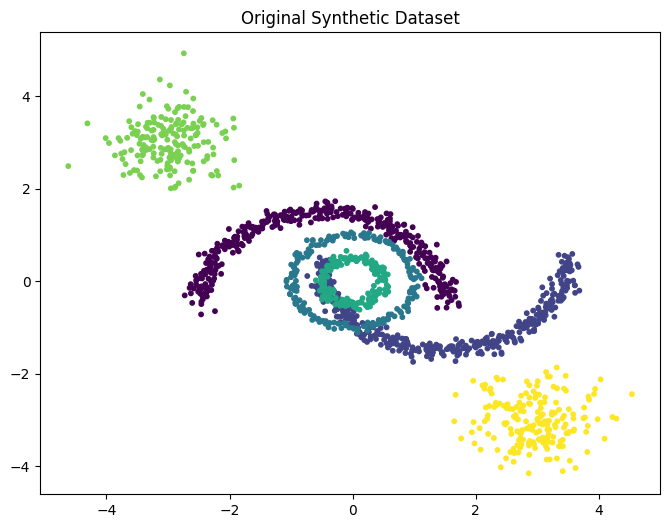

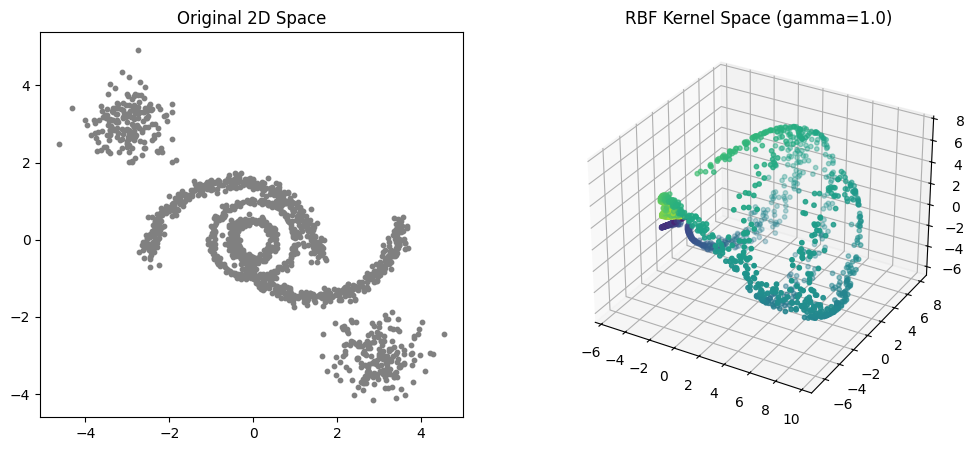

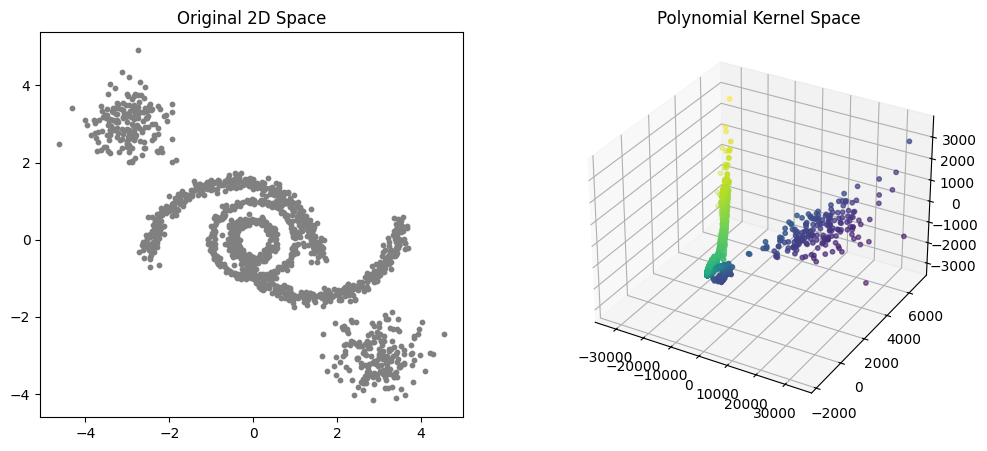

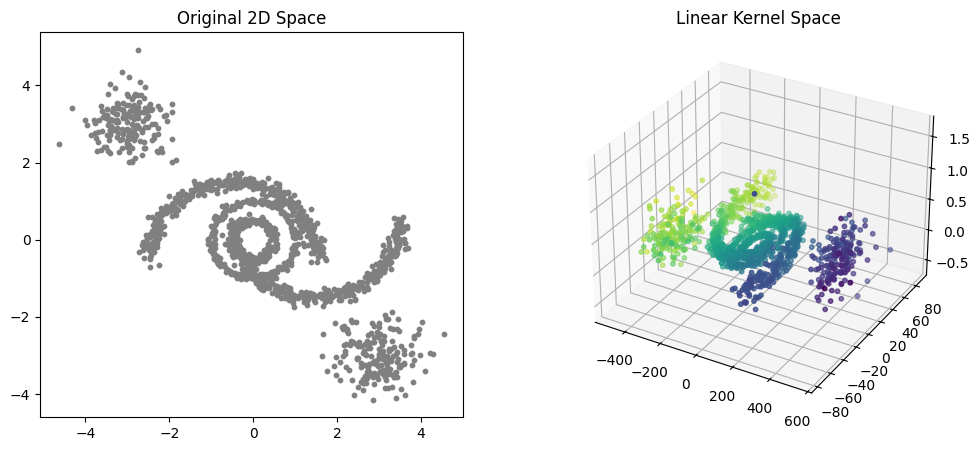

<ipython-input-6-3270543772>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=ListedColormap(plt.cm.get_cmap('viridis', params['n_clusters']).colors), s=10)
<ipython-input-6-3270543772>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=ListedColormap(plt.cm.get_cmap('viridis', params['n_clusters']).colors), s=10)
<ipython-input-6-3270543772>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pypl

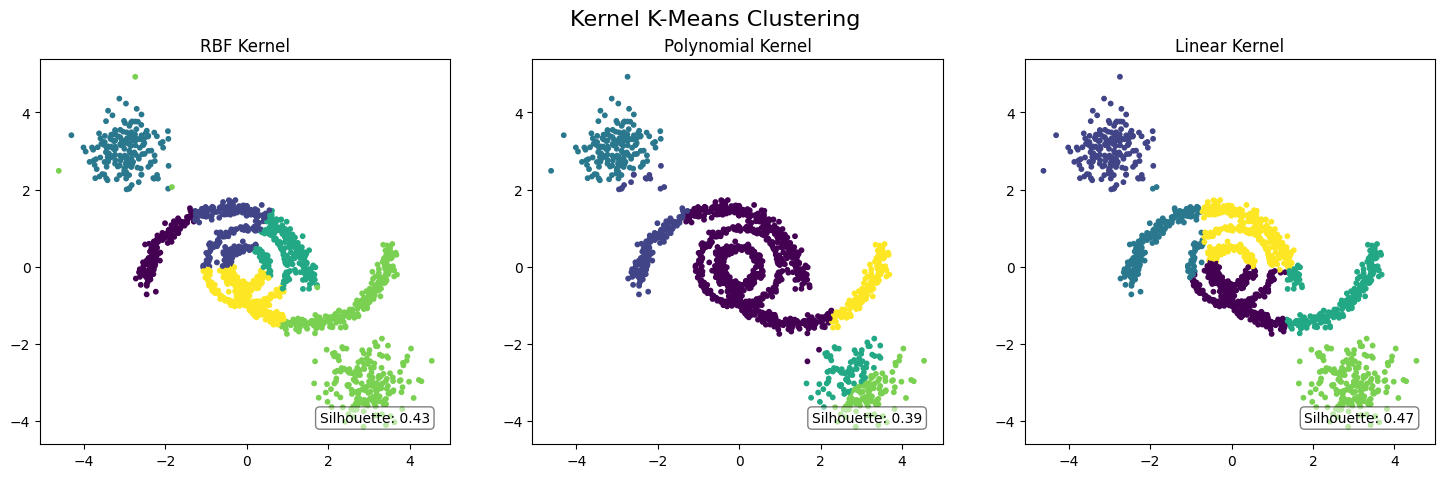

<ipython-input-6-3270543772>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap=ListedColormap(plt.cm.get_cmap('viridis', 6).colors), s=10)


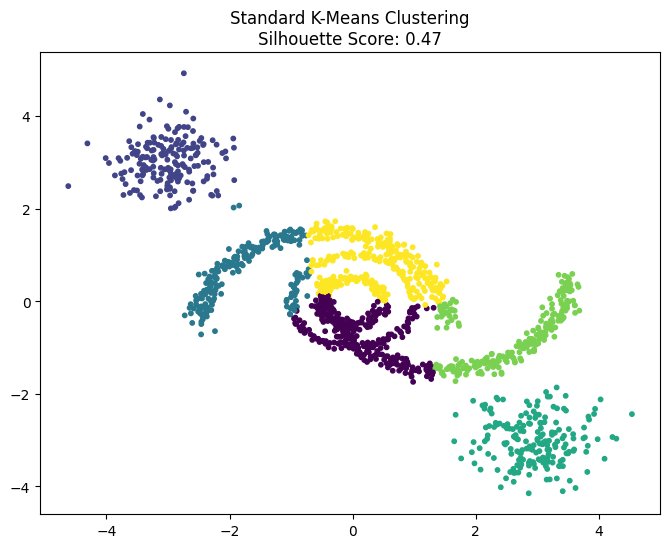

In [6]:
from sklearn.cluster import KMeans

#TODO:
# 1. Generate synthetic data
X, y_true = create_complex_dataset(n_samples=1500, random_state=42)

# 2. Visualize original data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap=ListedColormap(plt.cm.get_cmap('viridis', 6).colors), s=10)
plt.title("Original Synthetic Dataset")
plt.show()

# 3. Kernel space visualizations
plot_kernel_space(X, kernel="rbf", gamma=1.0, title="RBF Kernel Space (gamma=1.0)")
plot_kernel_space(X, kernel="polynomial", gamma=None, title="Polynomial Kernel Space") # Gamma is ignored
plot_kernel_space(X, kernel="linear", gamma=None, title="Linear Kernel Space") # Gamma is not used

# 4. Kernel K-Means clustering with different kernels
kernels = {
    "RBF": {"kernel": "rbf", "gamma": 1.0, "n_clusters": 6},
    "Polynomial": {"kernel": "polynomial", "n_clusters": 6},
    "Linear": {"kernel": "linear", "n_clusters": 6}
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Kernel K-Means Clustering", fontsize=16)

for i, (name, params) in enumerate(kernels.items()):
    model = KernelKMeans(**params, random_state=42)
    y_pred = model.fit_predict(X)

    axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=ListedColormap(plt.cm.get_cmap('viridis', params['n_clusters']).colors), s=10)
    axes[i].set_title(f"{name} Kernel")
    silhouette = silhouette_score(X, y_pred)
    axes[i].text(0.95, 0.05, f'Silhouette: {silhouette:.2f}', transform=axes[i].transAxes, ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
plt.show()

# 5. Compare with standard K-Means
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X)
silhouette_kmeans = silhouette_score(X, y_kmeans)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap=ListedColormap(plt.cm.get_cmap('viridis', 6).colors), s=10)
plt.title(f"Standard K-Means Clustering\nSilhouette Score: {silhouette_kmeans:.2f}")
plt.show()

## Kernel Ridge Regression with RBF Kernel for Sinusoidal Generation

###  What is Kernel Ridge Regression (KRR)?
**Kernel Ridge Regression (KRR)** combines:
- **Ridge Regression** – a linear model with L2 regularization to reduce overfitting.
- The **Kernel Trick** – a method to transform data into a higher-dimensional space to capture non-linear patterns.

This allows KRR to model complex, non-linear relationships using a linear model in a transformed space.

---

###  Why Use the RBF Kernel?
The **RBF (Radial Basis Function)** kernel is a widely used kernel function that maps data into an infinite-dimensional feature space. It is defined as:

$K(x, x') = \exp(-\gamma \|x - x'\|^2)$


- `γ` (gamma) controls the spread of the kernel.  
  - Large `γ`: Model focuses more locally.  
  - Small `γ`: Model considers a wider neighborhood of influence.

---

### Goal: Generate a Sinusoidal Function

We aim to use **KRR with the RBF kernel** to model and generate a smooth **sinusoidal waveform** from a small, noisy set of samples.


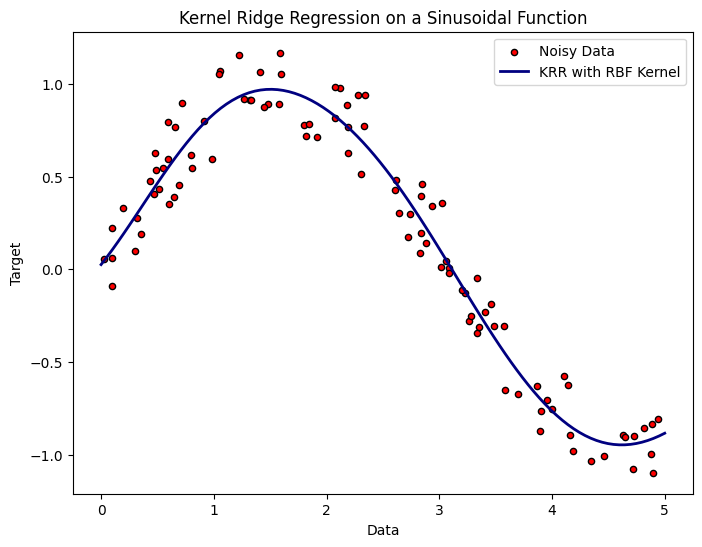

In [7]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

#TODO
rng = np.random.RandomState(0)
X = 5 * rng.rand(100, 1)
y = np.sin(X).ravel()

# Add noise to targets
y += 0.5 * (0.5 - rng.rand(y.shape[0]))

krr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.5)
krr.fit(X, y)

X_plot = np.linspace(0, 5, 100)[:, None]
y_pred = krr.predict(X_plot)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, c='red', label='Noisy Data', s=20, edgecolor='k')
plt.plot(X_plot, y_pred, color='navy', lw=2, label='KRR with RBF Kernel')
plt.xlabel('Data')
plt.ylabel('Target')
plt.title('Kernel Ridge Regression on a Sinusoidal Function')
plt.legend()
plt.show()


## KRR with laplacian kernel on moon dataset
The two moons dataset is a synthetic dataset consisting of two interleaved crescent shapes. It’s a classic test case for non-linear learning algorithms, because:

    The classes are not linearly separable.

    A simple linear regression or classifier would fail to capture the pattern.

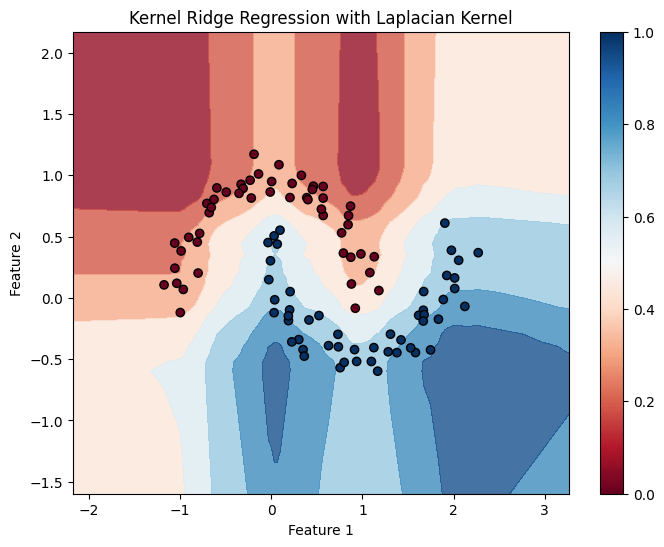

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
model = KernelRidge(alpha=0.1, kernel='laplacian', gamma=0.1)
model.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')
plt.title('Kernel Ridge Regression with Laplacian Kernel')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Dicision Tree

## download and load this dataset

In [9]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2025-06-11 16:19:43--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  14.9MB/s    in 6.9s    

2025-06-11 16:19:51 (11.7 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


## import neccesary libraries

In [10]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import os

# Download NLTK resources
def download_nltk_resources():
    try:
        nltk.download('punkt')  # Tokenizer
        nltk.download('stopwords')  # Common stopwords
        nltk.download('punkt_tab')  # Additional tokenizer data
    except Exception as e:
        print(f"Error downloading NLTK resources: {e}")

download_nltk_resources()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Data Loading
This function is responsible for loading and preparing a tweet dataset from the specified file path.

In [11]:
def load_tweets(filepath):
    """Load and prepare tweet dataset"""
    #TODO:note that convert label name to number for prediction
    column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

    tweet_dataset = pd.read_csv(filepath, encoding='latin-1', names=column_names)

    tweet_dataset = tweet_dataset[['text', 'target']]

    tweet_dataset['target'] = tweet_dataset['target'].replace(4, 1)

    tweet_dataset = shuffle(tweet_dataset).reset_index(drop=True)
    tweet_dataset =  tweet_dataset.head(100000)

    return tweet_dataset


## text preprocessing

This function takes a single tweet as input and applies cleaning and normalization steps to prepare the text for analysis or machine learning models.

### Parameters
- **tweet** (`str`): A raw tweet in string format.

### Returns
- **tweet** (`str`): The cleaned and normalized version of the original tweet.

### Notes
- **TODO**: Implement text preprocessing steps such as:
  - Lowercasing the text
  - Removing URLs, mentions, hashtags, and special characters
  - Tokenization and lemmatization
  - Removing stopwords

- It is recommended to use the **NLTK** library (`nltk`) for tokenization, stopword removal, and lemmatization.


In [12]:
def preprocess_tweet(tweet):
    """Clean and normalize tweet text"""
    #TODO : you can use the nltk library

    tweet = tweet.lower()

    tweet = re.sub(r'https?:\/\/\S+|www\.\S+', '', tweet)

    tweet = re.sub(r'@\w+', '', tweet)

    tweet = re.sub(r'#', '', tweet)

    tweet = re.sub(r'[^a-z\s]', '', tweet)
    tokens = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    tweet = ' '.join(filtered_tokens)

    return tweet

## Feature Extraction Methods

Feature extraction is the process of transforming raw text into numerical representations that can be used by machine learning models. Below are three commonly used methods:




### a) Simple Feature Extraction
This method involves extracting basic statistical or structural properties from the text, such as:
- Tweet length (number of characters or words)
- Number of hashtags, mentions, or URLs
- Presence of specific keywords
- Sentiment scores (optional)

These features are often handcrafted and can be useful for simple models or as supplementary features.

---


In [13]:
def extract_simple_features(data):
    """Basic text statistics features"""
    features = pd.DataFrame()
    features['length'] = data.apply(len)
    features['word_count'] = data.apply(lambda x: len(x.split()))

    return features.values

### b) Bag of Words (BoW) Features
The Bag of Words model converts text into a fixed-length vector by counting the frequency of each word in the vocabulary, ignoring grammar and word order. Steps typically include:
- Tokenizing the text
- Creating a vocabulary of all unique words in the dataset
- Representing each tweet as a vector of word counts

Useful for capturing word presence but not meaning or context.

---

In [14]:
def extract_bow_features(train_data, test_data):
    """Traditional word count features"""
    bow_vectorizer = CountVectorizer(max_features=1000)

    train_features = bow_vectorizer.fit_transform(train_data)

    test_features = bow_vectorizer.transform(test_data)

    return train_features, test_features


### c) TF-IDF Features
TF-IDF (Term Frequency–Inverse Document Frequency) improves upon BoW by reducing the weight of common words and increasing the weight of rare but important ones. The formula is:

TF-IDF(word) = TF(word in document) × IDF(word)

Where:
- **TF**: How often a word appears in a tweet
- **IDF**: How rare the word is across all tweets

TF-IDF helps highlight important and distinguishing words in the corpus and is widely used for text classification tasks.




In [15]:
def extract_tfidf_features(train_data, test_data):
    """Advanced word weighting features"""
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)

    train_features = tfidf_vectorizer.fit_transform(train_data)

    test_features = tfidf_vectorizer.transform(test_data)

    return train_features, test_features

## evaluate model

### Description
This function evaluates the performance of a trained machine learning model on test data. It calculates and displays key performance metrics, such as accuracy, and can be extended to include precision, recall, F1-score, and confusion matrix.

### Notes
- Consider using functions from `sklearn.metrics` such as `accuracy_score`, `classification_report`, and `confusion_matrix` to compute and display additional metrics.
- You can enhance this function to visualize performance using a confusion matrix heatmap (e.g., with `matplotlib` or `seaborn`).


In [16]:
def evaluate_model(model, x_test, y_test, model_name):
    """Calculate and display performance metrics"""
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)

    report = classification_report(y_test, y_pred)

    print(f"--- Performance for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("-" * 30)

    return accuracy

## main function

Now you must use the code and functions defined above to complete the pipeline in the `main()` function. Specifically, you should:

- Use `load_tweets(filepath)` to load the dataset.
- Apply `preprocess_tweet(tweet)` to clean and normalize each tweet.
- Use the three feature extraction methods (Simple Features, Bag-of-Words, TF-IDF) to convert text into numerical features.
- Train a Decision Tree model  on each set of features.
- Use `evaluate_model(model, x_test, y_test, model_name)` to assess model performance.
- Print and compare the results for each feature extraction approach.

This will allow you to build a full end-to-end tweet classification pipeline and evaluate the impact of different text representation techniques.


Starting the sentiment analysis pipeline...
Data loaded successfully.
Dataset shape: (100000, 2)
Preprocessing tweets...
Text preprocessing complete.
Data split into training and testing sets.
------------------------------
Starting model training and evaluation for each feature type...

--- Approach 1: Simple Features ---
--- Performance for Decision Tree with Simple Features ---
Accuracy: 0.5249
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      9981
           1       0.53      0.53      0.53     10019

    accuracy                           0.52     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.52      0.52      0.52     20000

------------------------------

--- Approach 2: Bag-of-Words (BoW) ---
--- Performance for Decision Tree with BoW ---
Accuracy: 0.6744
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67   

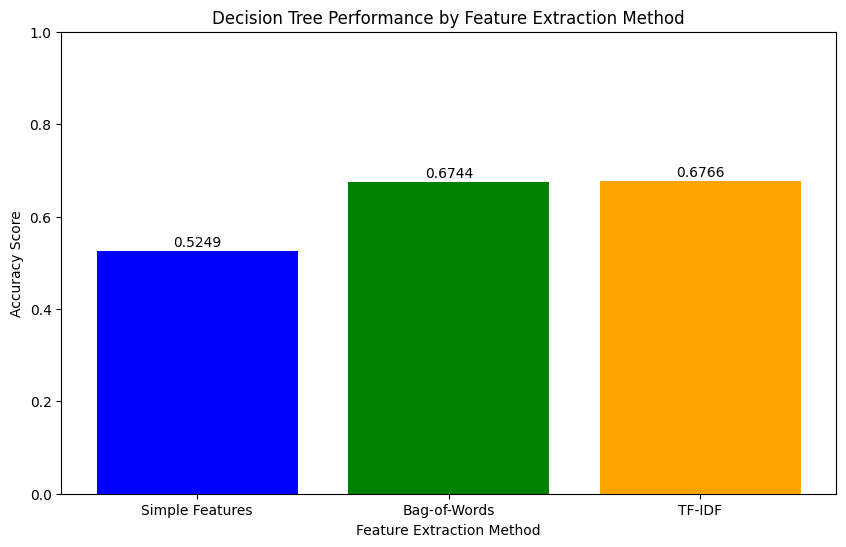


Pipeline execution finished.


In [17]:
def main():
    """Main function to run the ML pipeline"""
    print("Starting the sentiment analysis pipeline...")
    #TODO:
    # 1. Data Loading
    filepath = 'data/training.1600000.processed.noemoticon.csv'
    dataset = load_tweets(filepath)
    print("Data loaded successfully.")
    print(f"Dataset shape: {dataset.shape}")

    # 2. Text Preprocessing
    print("Preprocessing tweets...")
    dataset['cleaned_text'] = dataset['text'].apply(preprocess_tweet)
    print("Text preprocessing complete.")

    # 3. Prepare Data
    labels = dataset['target']

    x_train_text, x_test_text, y_train, y_test = train_test_split(
        dataset['cleaned_text'], labels, test_size=0.2, random_state=42, stratify=labels
    )
    print("Data split into training and testing sets.")
    print("-" * 30)

    results = {}

    print("Starting model training and evaluation for each feature type...")

    print("\n--- Approach 1: Simple Features ---")
    simple_features = extract_simple_features(dataset['cleaned_text'])
    x_train_simple, x_test_simple, y_train_simple, y_test_simple = train_test_split(
        simple_features, labels, test_size=0.2, random_state=42, stratify=labels
    )

    dt_simple = tree.DecisionTreeClassifier(random_state=42)
    dt_simple.fit(x_train_simple, y_train_simple)
    results['Simple Features'] = evaluate_model(dt_simple, x_test_simple, y_test_simple, "Decision Tree with Simple Features")

    print("\n--- Approach 2: Bag-of-Words (BoW) ---")
    x_train_bow, x_test_bow = extract_bow_features(x_train_text, x_test_text)

    dt_bow = tree.DecisionTreeClassifier(random_state=42)
    dt_bow.fit(x_train_bow, y_train)
    results['Bag-of-Words'] = evaluate_model(dt_bow, x_test_bow, y_test, "Decision Tree with BoW")

    print("\n--- Approach 3: TF-IDF ---")
    x_train_tfidf, x_test_tfidf = extract_tfidf_features(x_train_text, x_test_text)

    dt_tfidf = tree.DecisionTreeClassifier(random_state=42)
    dt_tfidf.fit(x_train_tfidf, y_train)
    results['TF-IDF'] = evaluate_model(dt_tfidf, x_test_tfidf, y_test, "Decision Tree with TF-IDF")

    print("\n--- Final Results Comparison ---")
    for method, acc in results.items():
        print(f"Accuracy for {method}: {acc:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange'])
    plt.xlabel('Feature Extraction Method')
    plt.ylabel('Accuracy Score')
    plt.title('Decision Tree Performance by Feature Extraction Method')
    plt.ylim(0, 1.0)

    for index, value in enumerate(results.values()):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center')

    plt.show()
    print("\nPipeline execution finished.")


if __name__ == '__main__':
    main()